# Teste de Random Survival Forest

C:\Users\gonca\AppData\Local\Temp\ipykernel_7092\1331213087.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["Genero"] = df_features["Genero"].map({"M": 1, "F": 0})
c:\Users\gonca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\gonca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\gonca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnorma

C-Index: 0.5467


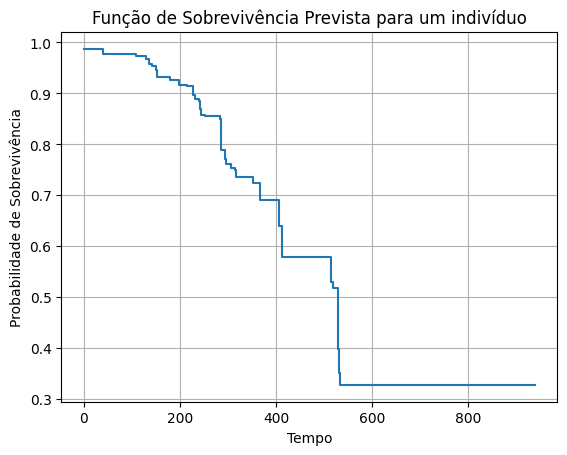

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Ler CSV
df = pd.read_csv("detectid_com_tempo.csv")

# Opcional: tratamento simples de dados (exemplo)
# Excluir linhas com missing para simplificar
df = df.dropna()
# Colunas para manter (features)
features = [
    "Genero",
    "Nível de Consciência",
    "Frequência Cardíaca",
    "TA Sistólica",
    "TA Diastólica",
    "Temperatura",
    "SpO2",
    "Necessidade de O2",
    "Dor"
    ]

df_features = df[features]
df_labels = df[["Tempo", "Evento"]]

# Opcional: tratar género como numérico (0/1)
df_features["Genero"] = df_features["Genero"].map({"M": 1, "F": 0})

X = df_features
y = Surv.from_dataframe("Evento", "Tempo", df)


# Normalizar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Criar e treinar RSF
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           random_state=42)
rsf.fit(X_train, y_train)

# Avaliar com C-Index
score = rsf.score(X_test, y_test)
print(f"C-Index: {score:.4f}")

surv_fn = rsf.predict_survival_function(X_test[:1])

# Os tempos para a função de sobrevivência são:
time_points = surv_fn[0].x  # tempos para o primeiro indivíduo

# As probabilidades de sobrevivência:
surv_prob = surv_fn[0].y

import matplotlib.pyplot as plt

plt.step(time_points, surv_prob, where="post")
plt.title("Função de Sobrevivência Prevista para um indivíduo")
plt.xlabel("Tempo")
plt.ylabel("Probabilidade de Sobrevivência")
plt.grid()
plt.show()



## Teste de PostgrSQL



In [8]:
import pandas as pd

# Lê os dois ficheiros
original = pd.read_csv("detectid_original.csv")  # substitui por caminho real
modificado = pd.read_csv("detectid.csv")

# Limpa nomes de colunas
original.columns = original.columns.str.strip().str.replace("\n", " ")
modificado.columns = modificado.columns.str.strip().str.replace("\n", " ")

# Verifica colunas diferentes
original_cols = set(original.columns)
modificado_cols = set(modificado.columns)

print("✅ Colunas no original e não no modificado:", original_cols - modificado_cols)
print("✅ Colunas no modificado e não no original:", modificado_cols - original_cols)

# Mantém só colunas comuns para comparação
common_cols = list(original_cols & modificado_cols)
original_common = original[common_cols].copy()
modificado_common = modificado[common_cols].copy()

# Ordena por colunas-chave
keys = ["Pessoa", "Dia de Medição", "Hora de Medição"]
keys = [k for k in keys if k in common_cols]

original_common.sort_values(by=keys, inplace=True)
modificado_common.sort_values(by=keys, inplace=True)

# Reindexa para alinhar
original_common.reset_index(drop=True, inplace=True)
modificado_common.reset_index(drop=True, inplace=True)

# Verifica diferença de número de linhas
if len(original_common) != len(modificado_common):
    print(f"⚠️ Número de linhas diferente: original={len(original_common)}, modificado={len(modificado_common)}")

# Alinha pelo menor número de linhas
min_len = min(len(original_common), len(modificado_common))
original_common = original_common.iloc[:min_len]
modificado_common = modificado_common.iloc[:min_len]

# Comparação final
diff = original_common.compare(modificado_common, align_axis=1)

if diff.empty:
    print("✅ Não há diferenças entre os dados comuns.")
else:
    print("⚠️ Diferenças encontradas nas colunas comuns:")
    print(diff)


✅ Colunas no original e não no modificado: {'Tempo', 'Area Monotorizada'}
✅ Colunas no modificado e não no original: {'Area\r Monotorizada'}
⚠️ Diferenças encontradas nas colunas comuns:
    Dia de Medição           
              self      other
170      2/12/2024  2/12/2023
173      3/12/2024  3/12/2023
174      3/12/2024  3/12/2023


In [1]:
import os

def tem_null_bytes(ficheiro):
    with open(ficheiro, 'rb') as f:
        return b'\x00' in f.read()

for root, _, files in os.walk('.'):
    for nome_ficheiro in files:
        if nome_ficheiro.endswith('.py'):
            caminho = os.path.join(root, nome_ficheiro)
            if tem_null_bytes(caminho):
                print(f"Null byte encontrado em: {caminho}")


tem_null_bytes("utentes/models.py")

Null byte encontrado em: .\utentes\models.py


True

In [6]:
import os

def tem_null_bytes(ficheiro):
    try:
        with open(ficheiro, 'rb') as f:
            conteudo = f.read()
            if b'\x00' in conteudo:
                print(f"❌ Null byte encontrado em: {ficheiro}")
                return True
    except Exception as e:
        print(f"Erro ao ler {ficheiro}: {e}")
    return False

for root, _, files in os.walk('.'):
    for nome_ficheiro in files:
        if nome_ficheiro.endswith('.py'):
            caminho = os.path.join(root, nome_ficheiro)
            tem_null_bytes(caminho)

❌ Null byte encontrado em: .\utentes\models.py


In [5]:
ficheiro = 'utentes/models.py'

with open(ficheiro, 'rb') as f:
    conteudo = f.read()

# Remove null bytes
conteudo_limpo = conteudo.replace(b'\x00', b'')

# Escreve de volta
with open(ficheiro, 'wb') as f:
    f.write(conteudo_limpo)

print("✅ Null bytes removidos de models.py")


✅ Null bytes removidos de models.py


In [ ]:
import pandas as pd
import random

file_path = "detectid.csv"
df = pd.read_csv(file_path)

# Processamento dos tipos
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# NIVEL DE CONSCIÊNCIA como inteiro com média preenchida
df["NIVEL DE CONSCIÊNCIA"] = pd.to_numeric(df["NIVEL DE CONSCIÊNCIA"], errors='coerce')
media_nivel = int(df["NIVEL DE CONSCIÊNCIA"].mean().round())
df["NIVEL DE CONSCIÊNCIA"].fillna(media_nivel, inplace=True)

# Criar datetime auxiliar para ordenação e cálculo
df["datetime"] = pd.to_datetime(df["Dia de Medição"] + " " + df["Hora de Medição"], dayfirst=True, errors="coerce")

# Extrair ID da pessoa
df["person_id"] = df["Pessoa"].str.extract(r"(\d+)").astype(int)

# Calcular tempo em horas desde a 1ª medição da pessoa
df.sort_values(by=["person_id", "datetime"], inplace=True)
df["Tempo"] = df.groupby("person_id")["datetime"].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)
df["Tempo"] = df["Tempo"].round(2)

# Manter a Data de Nascimento no formato original (não transformar para datetime.date)
# Garante que a coluna é string e tem o formato correto
df["Data de Nascimento"] = df["Data de Nascimento"].astype(str).str.strip()

# Guardar novo CSV com a coluna "Tempo"
df.to_csv("detectid_com_tempo.csv", index=False)


C:\Users\gonca\AppData\Local\Temp\ipykernel_15392\2830958062.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["NIVEL DE CONSCIÊNCIA"].fillna(media_nivel, inplace=True)


In [24]:
import psycopg2

conn = psycopg2.connect(
    dbname="detectid",
    user="postgres",
    password="Goncalo123",
    host="localhost"
)

cur = conn.cursor()
cur.execute("SELECT * FROM cdmdatabaseschema.person LIMIT 5;")
print(cur.fetchall())

cur.close()
conn.close()

[]


### Carregar Ficheiro

In [25]:
import pandas as pd


file_path = "detectid.csv"
df = pd.read_csv(file_path)


df.head()

,Pessoa,Tempo,Primeiro Nome,Último Nome,Dia de Medição,Hora de Medição,Data de Nascimento,Genero,Serviço,NIVEL DE CONSCIÊNCIA,...,TEMPERATURA,SpO2,NECESSIDADE DE O2,DOR,DESCOMPENSAÇÃO,Ativação Médico,Aumento da Vigilância,Via Área Ameaçada,Evento,Area\nMonotorizada
0,Pessoa 1,0.0,Miguel,Almeida,11/11/2023,11:00,04/08/1965,Masculino,1,15,...,37.1,94.0,1.0,0.0,0.0,0.0,0.0,0.0,0,NaN
1,Pessoa 1,125.5,Miguel,Almeida,16/11/2023,18:30,04/08/1965,Masculino,2,15,...,37.1,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,Pessoa 1,127.5,Miguel,Almeida,16/11/2023,20:30,04/08/1965,Masculino,2,15,...,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.0,1,1.0
3,Pessoa 1,133.0,Miguel,Almeida,17/11/2023,02:00,04/08/1965,Masculino,2,15,...,36.8,96.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1.0
4,Pessoa 1,138.5,Miguel,Almeida,17/11/2023,7:30,04/08/1965,Masculino,2,15,...,37.1,NaN,0.0,0.0,1.0,0.0,1.0,0.0,1,1.0


### Tratemento dos Dados

Aqui chatgpt para tratamento dos dados -> Rever isto tudo

In [26]:
# Tempo tem que ser calculado logo nao entra na base de dados
# Evento foi uma experiencia, tambem nao entra
df_cleaned = df.drop(columns=["Tempo", "Evento"])

df_cleaned.rename(columns=lambda x: x.strip().replace("\n", " "), inplace=True)

# Valores Omissos preenchidos com média
numeric_cols = df_cleaned.select_dtypes(include='number').columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].mean())

# Converter para numérico (caso haja strings ou espaços)
df_cleaned["NIVEL DE CONSCIÊNCIA"] = pd.to_numeric(df_cleaned["NIVEL DE CONSCIÊNCIA"], errors='coerce')

# Calcular a média ignorando os NaNs e arredondar para inteiro
media_nivel = int(df_cleaned["NIVEL DE CONSCIÊNCIA"].mean().round())

# Preencher os NaNs com a média
df_cleaned["NIVEL DE CONSCIÊNCIA"].fillna(media_nivel, inplace=True)

# Garantir que 'Dia' e 'Hora' são string
df_cleaned["Dia de Medição"] = df_cleaned["Dia de Medição"].astype(str)
df_cleaned["Hora de Medição"] = df_cleaned["Hora de Medição"].astype(str)

# Juntar as colunas 'Dia' e 'Hora' e converter para datetime com formato automático
df_cleaned["datetime"] = pd.to_datetime(df_cleaned["Dia de Medição"] + " " + df_cleaned["Hora de Medição"], dayfirst=True, errors="coerce")

df_cleaned["person_id"] = df_cleaned["Pessoa"].str.extract(r"(\d+)").astype(int)

# Ver exemplo de dados limpos e prontos para inserção
print(df_cleaned.to_string())


         Pessoa Primeiro Nome Último Nome Dia de Medição Hora de Medição Data de Nascimento      Genero  Serviço  NIVEL DE CONSCIÊNCIA  FREQUÊNCIA CARDIACA  TA Sistólica  TA Diastólica  TEMPERATURA        SpO2  NECESSIDADE DE O2       DOR  DESCOMPENSAÇÃO  Ativação Médico  Aumento da Vigilância  Via Área Ameaçada  Area Monotorizada            datetime  person_id
0      Pessoa 1        Miguel     Almeida     11/11/2023           11:00         04/08/1965   Masculino        1                  15.0           103.000000    109.000000      61.000000    37.100000   94.000000           1.000000  0.000000        0.000000         0.000000               0.000000               0.00           0.088889 2023-11-11 11:00:00          1
1      Pessoa 1        Miguel     Almeida     16/11/2023           18:30         04/08/1965   Masculino        2                  15.0            99.000000    110.000000      74.000000    37.100000   96.000000           0.000000  0.000000        0.000000         0.000000 

C:\Users\gonca\AppData\Local\Temp\ipykernel_5752\1629630894.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned["NIVEL DE CONSCIÊNCIA"].fillna(media_nivel, inplace=True)


### Inserção dos dados PERSON

In [27]:
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values

# Conectar à base de dados
conn = psycopg2.connect(
    dbname="detectid",
    user="postgres",
    password="Goncalo123",
    host="localhost",
    port="5432"
)

cur = conn.cursor()

rows = []
person_id = 0
for _, row in df_cleaned.iterrows():
        if person_id < row["person_id"]:
            person_id = row["person_id"]
            genero = 1 if row['Genero'] == 'Masculino' else 0
            rows.append((
                person_id,
                genero,
                "12345555",
                row["Data de Nascimento"],
                row["Primeiro Nome"],
                row["Último Nome"]
            ))

query = """
INSERT INTO cdmDatabaseSchema.PERSON (
    person_id, gender_concept_id, person_source_value, birthday, first_name, last_name
) VALUES %s
"""

execute_values(cur, query, rows)
conn.commit()

print("Dados PERSON inseridos com sucesso!")

cur.close()
conn.close()


Dados PERSON inseridos com sucesso!


### Inserção dos Dados MEASUREMENT

In [28]:
# Conectar à base de dados
conn = psycopg2.connect(
    dbname="detectid",
    user="postgres",
    password="Goncalo123",
    host="localhost",
    port="5432"
)

cur = conn.cursor()

# Exemplo de inserção na tabela MEASUREMENT
measurement_concepts = {
    "SpO2": 1,
    "NECESSIDADE DE O2": 2,
    "FREQUÊNCIA CARDIACA": 3,
    "TA Sistólica": 4,
    "TA Diastólica": 5,
    "TEMPERATURA": 6,
    "NIVEL DE CONSCIÊNCIA": 7,
    "DOR": 8,
}

measurement_id = 1
rows = []
for _, row in df_cleaned.iterrows():
    for field, concept_id in measurement_concepts.items():
        rows.append((
            measurement_id,
            int(row["person_id"]),
            concept_id,
            row[field],
            row["datetime"]
        ))
        measurement_id += 1

query = """
INSERT INTO cdmDatabaseSchema.MEASUREMENT (
    measurement_id, person_id, measurement_concept_id, value_as_number, measurement_datetime
) VALUES %s
"""


execute_values(cur, query, rows)
conn.commit()

print("Dados MEASUREMENT inseridos com sucesso!")
cur.close()
conn.close()


Dados MEASUREMENT inseridos com sucesso!


### Inserção dos Dados CONDITION_OCCURENCE
Diagnósticos
	
	condition_occurrence_id integer PRIMARY KEY,	
    person_id integer NOT NULL,				
    condition_start_date date NOT NULL, 
    condition_source_value varchar(50) NOT NULL,


In [29]:
import psycopg2
from psycopg2.extras import execute_values
import pandas as pd
import random


diagnosticos = [
    "Hipertensão arterial", "Diabetes tipo 2", "Insuficiência cardíaca", "DPOC", "Asma",
    "Enfarte agudo do miocárdio", "AVC isquémico", "Pneumonia", "Fratura do fémur", "Cancro do pulmão",
    "Insuficiência renal crónica", "Hepatite C", "Cirrose hepática", "Septicemia", "Hipotiroidismo",
    "Doença de Alzheimer", "Parkinson", "Lombalgia crónica", "Esquizofrenia", "Transtorno bipolar",
    "Depressão major", "Anemia ferropriva", "Gastrite aguda", "Úlcera péptica", "Infecção urinária",
    "COVID-19", "Apneia do sono"
]


primeiras_datas = (
    df_cleaned.groupby("person_id")["datetime"].min().reset_index()
)

rows = []
for i, row in primeiras_datas.iterrows():
    condition_occurrence_id = i + 1
    person_id = row["person_id"]
    condition_start_date = row["datetime"].date()  
    diagnostico = random.choice(diagnosticos)

    rows.append((
        condition_occurrence_id,
        person_id,
        condition_start_date,
        diagnostico
    ))

# Inserção na base de dados
conn = psycopg2.connect(
    dbname="detectid",
    user="postgres",
    password="Goncalo123",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

query = """
INSERT INTO cdmDatabaseSchema.CONDITION_OCCURRENCE (
    condition_occurrence_id,
    person_id,
    condition_start_date,
    condition_source_value
) VALUES %s
"""

execute_values(cur, query, rows)
conn.commit()

print("Dados CONDITION_OCCURRENCE inseridos com sucesso!")

cur.close()
conn.close()


Dados CONDITION_OCCURRENCE inseridos com sucesso!


### Inserção dos Dados NOTE
Queixas de Entrada, Alergias

	note_id integer PRIMARY KEY,		-- Id
	person_id integer NOT NULL,		-- Utente
	note_text TEXT NOT NULL,		-- Texto da nota
	note_type_concept_id integer NOT NULL -- Tipo de Nota


In [30]:
import random

# Inserção na base de dados
conn = psycopg2.connect(
    dbname="detectid",
    user="postgres",
    password="Goncalo123",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

queixas = [
    "Dor abdominal", "Tosse persistente", "Febre alta", "Fadiga extrema",
    "Dificuldade respiratória", "Vómitos", "Tonturas", "Palpitações"
]

alergias = [
    "Alergia a penicilina", "Intolerância à lactose", "Alergia a frutos secos",
    "Alergia a marisco", "Alergia ao pólen", "Alergia a anti-inflamatórios"
]

note_rows = []
note_id = 1
note_type_queixa = 1  # Queixas de Entrada
note_type_alergia = 2  # Alergia


pessoas_unicas = df_cleaned["person_id"].unique()

for person_id in pessoas_unicas:
    
    note_rows.append((
        note_id,
        int(person_id), # Para não ter erro de tipo
        random.choice(queixas), #Adiciona uma queixa ao calhas das acima
        note_type_queixa
    ))
    note_id += 1

    # Nem todos têm alergias
    if random.random() < 0.5:
        note_rows.append((
            note_id,
            int(person_id), # Para não ter erro de tipo
            random.choice(alergias), #Adiciona uma alergia ao calhas das acima
            note_type_alergia
        ))
        note_id += 1

# Inserir na base de dados
note_query = """
INSERT INTO cdmDatabaseSchema.NOTE (
    note_id, person_id, note_text, note_type_concept_id
) VALUES %s
"""
execute_values(cur, note_query, note_rows)
conn.commit()

print("Notas inseridas com sucesso!")


Notas inseridas com sucesso!


### Inserção dos Dados OBSERVATION
Evento

	observation_id integer PRIMARY KEY,		-- Id
	person_id integer NOT NULL,				-- Utente
	observation_concept_id integer NOT NULL, -- Tipo de Observação
    value_as_number NUMERIC NULL,            -- 0 Nao aconteceu, 1 aconteceu
	observation_datetime timestamp NOT NULL -- Data de Observação

In [31]:
# Conectar à base de dados
conn = psycopg2.connect(
    dbname="detectid",
    user="postgres",
    password="Goncalo123",
    host="localhost",
    port="5432"
)

cur = conn.cursor()


events = {
    "DESCOMPENSAÇÃO": 1,
    "Ativação Médico": 2,
    "Aumento da Vigilância": 3,
    "Via Área Ameaçada": 4
}

event_id = 1
rows = []
for _, row in df_cleaned.iterrows():
    for field, concept_id in events.items():
        rows.append((
            event_id,
            int(row["person_id"]),
            concept_id,
            row[field],
            row["datetime"]
        ))
        event_id += 1

query = """
INSERT INTO cdmDatabaseSchema.OBSERVATION (
    observation_id, person_id, observation_concept_id, value_as_number, observation_datetime
) VALUES %s
"""


execute_values(cur, query, rows)
conn.commit()

print("Dados OBSERVATION inseridos com sucesso!")
cur.close()
conn.close()


Dados OBSERVATION inseridos com sucesso!


### Inserção dos Dados VISIT_OCCURENCE
Hora de Internamento, Alta, Serviço 

	visit_occurrence_id integer PRIMARY KEY,	-- Id
	person_id integer NOT NULL,			-- Utente
	care_site_id integer NULL, 			-- Serviço    1 -> Urgência, 2-> Internamento, 3-> UCI
	visit_start_datetime timestamp NOT NULL, -- Hora e Data de Internamento
	visit_end_datetime timestamp NULL -- Hora e Data de Alta

In [32]:
# Encontrar o índice da primeira medição por pessoa
idx_primeiras = df_cleaned.groupby("person_id")["datetime"].idxmin()

# Usar esses índices para obter as linhas completas (incluindo "Serviço")
primeiras_datas = df_cleaned.loc[idx_primeiras, ["person_id", "datetime", "Serviço"]].reset_index(drop=True)

rows = []
for i, row in primeiras_datas.iterrows():
    visit_occurrence_id = i + 1
    person_id = row["person_id"]
    care_site_id = row["Serviço"]
    visit_start_datetime = row["datetime"] 

    rows.append((
        visit_occurrence_id,
        person_id,
        care_site_id,
        visit_start_datetime
    ))

# Inserção na base de dados
conn = psycopg2.connect(
    dbname="detectid",
    user="postgres",
    password="Goncalo123",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

query = """
INSERT INTO cdmDatabaseSchema.VISIT_OCCURRENCE (
    visit_occurrence_id,
    person_id,
    care_site_id,
    visit_start_datetime
) VALUES %s
"""

execute_values(cur, query, rows)
conn.commit()

print("Dados VISIT_OCCURRENCE inseridos com sucesso!")

cur.close()
conn.close()

Dados VISIT_OCCURRENCE inseridos com sucesso!


### Extração dos Dados da BD para Dataset

In [33]:
# # Inserção na base de dados
# conn = psycopg2.connect(
#     dbname="detectid",
#     user="postgres",
#     password="Goncalo123",
#     host="localhost",
#     port="5432"
# )


# query = """
# SELECT
#   pd.first_name || ' ' || pd.last_name AS pessoa,
#   TO_CHAR(
#     TO_DATE(
#       p.year_of_birth || '-' || COALESCE(p.month_of_birth, 1) || '-' || COALESCE(p.day_of_birth, 1),
#       'MM-DD-YYYY'
#     ),
#     'MM-DD-YYYY'
#   ) AS data_nascimento,
#   CASE p.gender_concept_id
#     WHEN 1 THEN 'Masculino'
#     WHEN 0 THEN 'Feminino'
#     ELSE 'Outro'
#   END AS genero,
#   v.care_site_id AS servico,
#   DATE(m.measurement_datetime) AS dia_de_medicao,
#   TO_CHAR(m.measurement_datetime, 'HH24:MI') AS hora_de_medicao,

#   MAX(CASE WHEN m.measurement_concept_id = 1 THEN m.value_as_number END) AS ta_sistolica,
#   MAX(CASE WHEN m.measurement_concept_id = 2 THEN m.value_as_number END) AS ta_diastolica,
#   MAX(CASE WHEN m.measurement_concept_id = 3 THEN m.value_as_number END) AS temperatura,
#   MAX(CASE WHEN m.measurement_concept_id = 4 THEN m.value_as_number END) AS spo2,
#   MAX(CASE WHEN m.measurement_concept_id = 5 THEN m.value_as_number END) AS dor,
#   MAX(CASE WHEN m.measurement_concept_id = 6 THEN m.value_as_number END) AS necessidade_o2,
#   MAX(CASE WHEN m.measurement_concept_id = 7 THEN m.value_as_number END) AS frequencia_cardiaca,
#   MAX(CASE WHEN m.measurement_concept_id = 8 THEN m.value_as_number END) AS nivel_consciencia,

#   MAX(CASE WHEN o.observation_concept_id = 1 THEN o.value_as_number END) AS descompensacao,
#   MAX(CASE WHEN o.observation_concept_id = 2 THEN o.value_as_number END) AS ativacao_medico,
#   MAX(CASE WHEN o.observation_concept_id = 3 THEN o.value_as_number END) AS aumento_vigilancia,
#   MAX(CASE WHEN o.observation_concept_id = 4 THEN o.value_as_number END) AS via_aerea_ameacada

# FROM cdmDatabaseSchema.MEASUREMENT m
# JOIN cdmDatabaseSchema.PERSON p ON p.person_id = m.person_id
# JOIN cdmDatabaseSchema.PERSON_DETAILS pd ON pd.person_id = p.person_id
# JOIN cdmDatabaseSchema.VISIT_OCCURRENCE v ON v.person_id = p.person_id
# LEFT JOIN cdmDatabaseSchema.OBSERVATION o ON o.person_id = p.person_id
#     AND DATE(o.observation_datetime) = DATE(m.measurement_datetime)
#     AND EXTRACT(HOUR FROM o.observation_datetime) = EXTRACT(HOUR FROM m.measurement_datetime)
#     AND EXTRACT(MINUTE FROM o.observation_datetime) = EXTRACT(MINUTE FROM m.measurement_datetime)

# GROUP BY
#   pd.first_name, pd.last_name,
#   p.year_of_birth, p.month_of_birth, p.day_of_birth,
#   p.gender_concept_id,
#   v.care_site_id,
#   DATE(m.measurement_datetime),
#   TO_CHAR(m.measurement_datetime, 'HH24:MI')
# ORDER BY
#   pessoa, dia_de_medicao, hora_de_medicao;
# """


# df = pd.read_sql(query, conn)
# df.to_csv("exportacao_dados_clinicos.csv", index=False)


# conn.close()

# print("Exportação completa para 'exportacao_dados_clinicos.csv'")
